In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
)

In [3]:
categorical = ["lead_source", "industry", "employment_status", "location"]
numerical = ["number_of_courses_viewed", "annual_income", "interaction_count", "lead_score"]

In [4]:
df[categorical] = df[categorical].fillna("NA")
df[numerical] = df[numerical].fillna(0.0)

In [7]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [8]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [29]:
from sklearn.metrics import auc, roc_auc_score

for num in numerical:
    score = roc_auc_score(y_train, df_train[num])
    print(num, score)

number_of_courses_viewed 0.7635680590007088
annual_income 0.5519578313253012
interaction_count 0.738270176293409
lead_score 0.6144993577250176


In [104]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
def train_model(m_df, m_y, m_c = 1.0):
    dicts = m_df[categorical + numerical].to_dict(orient="records")
    m_dv = DictVectorizer(sparse=False)
    m_X_train = m_dv.fit_transform(dicts)
    m_model = LogisticRegression(solver='liblinear', C=m_c, max_iter=1000)
    m_model.fit(m_X_train, m_y)
    return m_dv, m_model

In [32]:
def predict_model(m_df, m_dv, m_model):
    p_dicts = m_df[categorical + numerical].to_dict(orient="records")
    p_X = m_dv.transform(p_dicts)
    p_y_pred = m_model.predict_proba(p_X)[:,1]
    return p_y_pred

In [71]:
dv, model = train_model(df_train, y_train)
y_pred = predict_model(df_val, dv ,model)
auc = roc_auc_score(y_val, y_pred)
auc

0.8171316268814112

In [91]:
precision, recall, axis, f1 = [], [], [], []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    if tp + fp != 0 and tp + fn != 0:
        p = tp / (tp + fp)
        r = tp / (tp + fn)
        precision.append(p)
        recall.append(r)
        axis.append(t)
        f1.append(2 * p * r / (p+r))

In [92]:
len(precision), len(recall)

(98, 98)

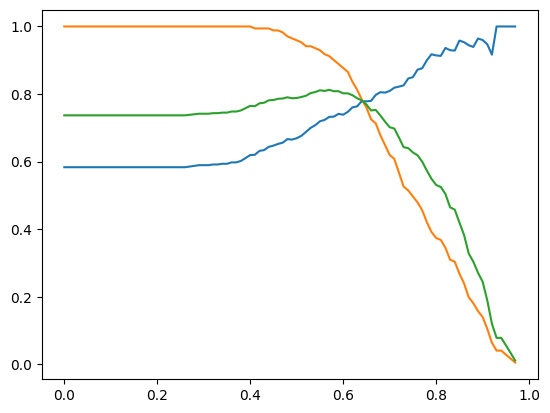

In [93]:
from matplotlib import pyplot as plt
plt.plot(axis, precision, label="Precision-recall curve")
plt.plot(axis, recall, label="Precision-recall curve")
plt.plot(axis, f1, label="Precision-recall curve")

In [95]:
print(max(f1))
print(np.argmax(f1))
print(axis[np.argmax(f1)])

0.8124999999999999
57
0.5700000000000001


In [62]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
thresholds = np.append(thresholds, np.array([1.0]))

In [69]:
len(precision), len(recall), len(thresholds)

(294, 294, 294)

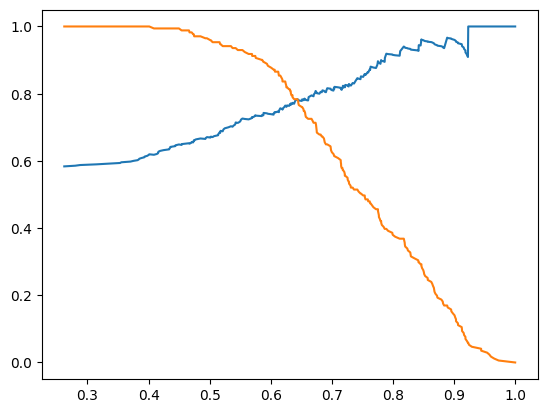

In [66]:
from matplotlib import pyplot as plt
plt.plot(thresholds, precision, label="Precision-recall curve")
plt.plot(thresholds, recall, label="Precision-recall curve")

In [106]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [100]:
from tqdm import tqdm
scores = []
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = df_train.converted.values
    y_val = df_val.converted.values
    dv, model = train_model(df_train, y_train)
    y_pred = predict_model(df_val, dv ,model)
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

5it [00:00, 82.97it/s]


In [102]:
np.std(scores)

np.float64(0.03580711942905165)

In [103]:
scores

[0.8060745924216483,
 0.8713738368910783,
 0.7754320118852139,
 0.8018368617683685,
 0.8558272713202291]

In [107]:
for c_v in [0.000001, 0.001, 1]:
    scores = []
    for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_train = df_train.converted.values
        y_val = df_val.converted.values
        dv, model = train_model(df_train, y_train, m_c=c_v)
        y_pred = predict_model(df_val, dv ,model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print(c_v, np.mean(scores), np.std(scores))

5it [00:00, 84.98it/s]


1e-06 0.560207852870275 0.023798316620649906


5it [00:00, 85.06it/s]


0.001 0.8668780317675395 0.028746230508215103


5it [00:00, 86.99it/s]

1 0.8221089148573075 0.03580711942905165
